In [25]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [24]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
import ipywidgets as widgets
%matplotlib notebook

In [19]:
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f
def sort_data(x,y):
    lists = sorted(itertools.izip(*[x, y]))
    new_x, new_y = list(itertools.izip(*lists))
    return new_x, new_y

# Better way

In [22]:
#phivals = [float(i)/100.0 for i in sys.argv[1:]]

phivals = [40.,45.,50.,54.,55.,56.]
#solid part
ialist = ['tot','hd','lub','rep','fric']

folders = get_folder_list()
db = dict()
for p in phivals:
    db[p] = dict()
    db[p]['shearstress'] = []
    for ia in ialist:
        db[p][ia] = [[],[],[]]

def num_points(max_strain):
    if max_strain < 1.0: return -5
    elif (max_strain >= 1.0) and (max_strain <=2.0): return -10

f = FloatProgress(min=0, max=100)
display(f)
L = widgets.Label("")
display(L)
progress = widgets.Label("")
display(progress)

type = 'mean' #type is 'mean' or 'all' or 'half' or 'laststrain'

for num,folder in enumerate(np.sort(folders[:])):
    try:
        path = folder+"/result/part_stress_norm_tot_t.dat"
        if os.path.exists(path):
            exp = reader.DataSet(folder, fluid=False, particles=True)
            exp.LoadState(exp.tlist[-1])
            
            max_strain = float(exp.t)*exp.shearrate*exp.dt
            n = len(exp.tlist[1:])
            if max_strain >= 2:
                n_last_strain = int(float(n)/max_strain*(max_strain - 1))
            else:
                n_last_strain = -10
                
            f.value = float(num+1)/len(folders[:])*100
            L.value = folder
            p = round(exp.phi*100)
            db_visc = pd.read_csv(folder+"/result/nu_t.dat")
            visc = db_visc[db_visc.columns[2]]
            time = db_visc[db_visc.columns[0]]
            shearstress = np.multiply(visc,exp.shearrate)
            type = 'mean'
            if type == 'mean':
                shearstress = np.mean(shearstress[n_last_strain:])
                db[p]['shearstress'].append(shearstress)
            if type == 'last':
                shearstress = shearstress[-20:]
                db[p]['shearstress'].extend(list(shearstress))
            if type == 'half':
                shearstress = shearstress[int(len(shearstress)/2):]
                db[p]['shearstress'].extend(list(shearstress))
            if type == 'laststrain':
                shearstress = shearstress[n_last_strain:]
                db[p]['shearstress'].extend(list(shearstress))
                
            for ia in ialist:
                path = folder+"/result/part_stress_norm_"+ia+"_t.dat"
                df = pd.read_csv(path)
                s11 = np.asarray(df[df.columns[2]])
                s22 = np.asarray(df[df.columns[3]])
                s33 = np.asarray(df[df.columns[4]])
                if type == 'last':
                    s11 = s11[-20:]
                    s22 = s22[-20:]
                    s33 = s33[-20:]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)
                if type == 'laststrain':
                    s11 = s11[n_last_strain:]
                    s22 = s22[n_last_strain:]
                    s33 = s33[n_last_strain:]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)                
                if type == 'half':
                    s11 = s11[int(len(s11)/2):]
                    s22 = s22[int(len(s22)/2):]
                    s33 = s33[int(len(s33)/2):]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)                    
                if type == 'mean':
                    s11 = np.mean(s11[n_last_strain:])
                    s22 = np.mean(s22[n_last_strain:])
                    s33 = np.mean(s33[n_last_strain:])
                    db[p][ia][0].append(s11)
                    db[p][ia][1].append(s22)
                    db[p][ia][2].append(s33)

    except Exception as e: 
        print str(e)
        continue

for p in db.keys():
    for q in db[p].keys():
        db[p][q] = np.asarray(db[p][q])

File rhor1_phi45_yd70.0/result/nu_t.dat does not exist


<IPython.core.display.Javascript object>


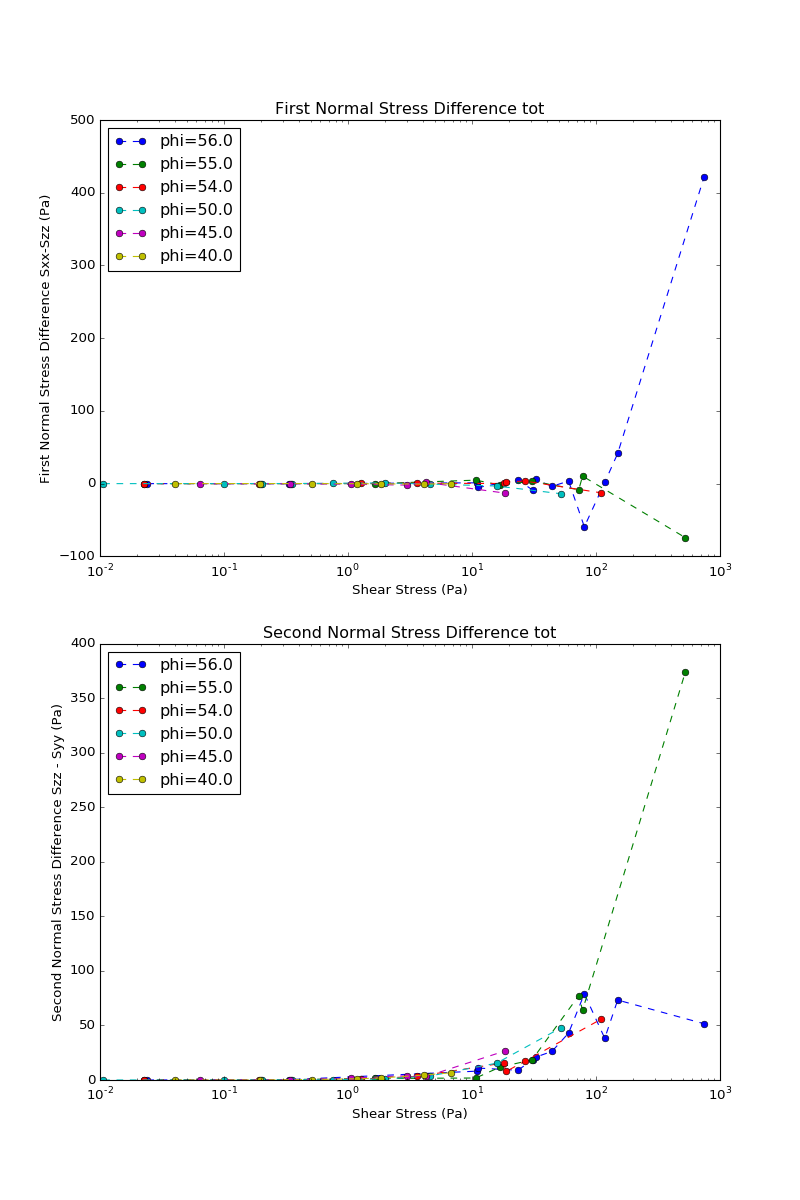

<IPython.core.display.Javascript object>


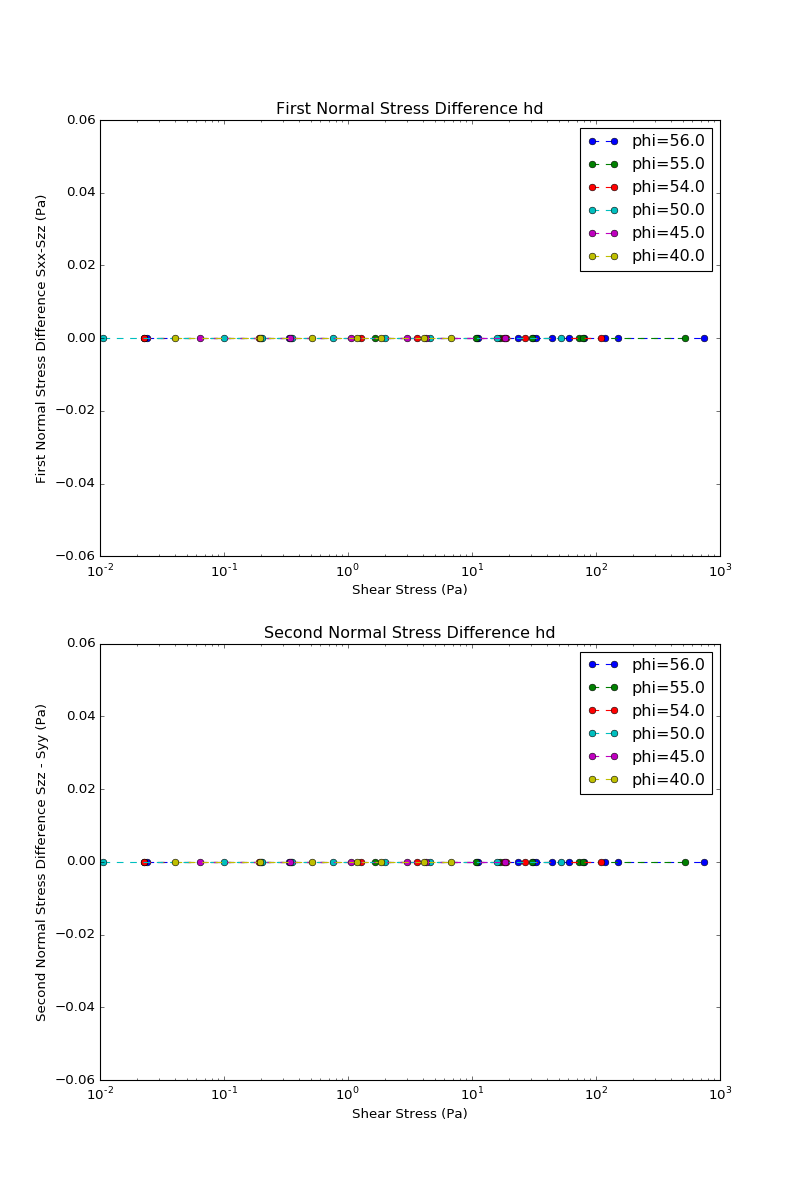

<IPython.core.display.Javascript object>


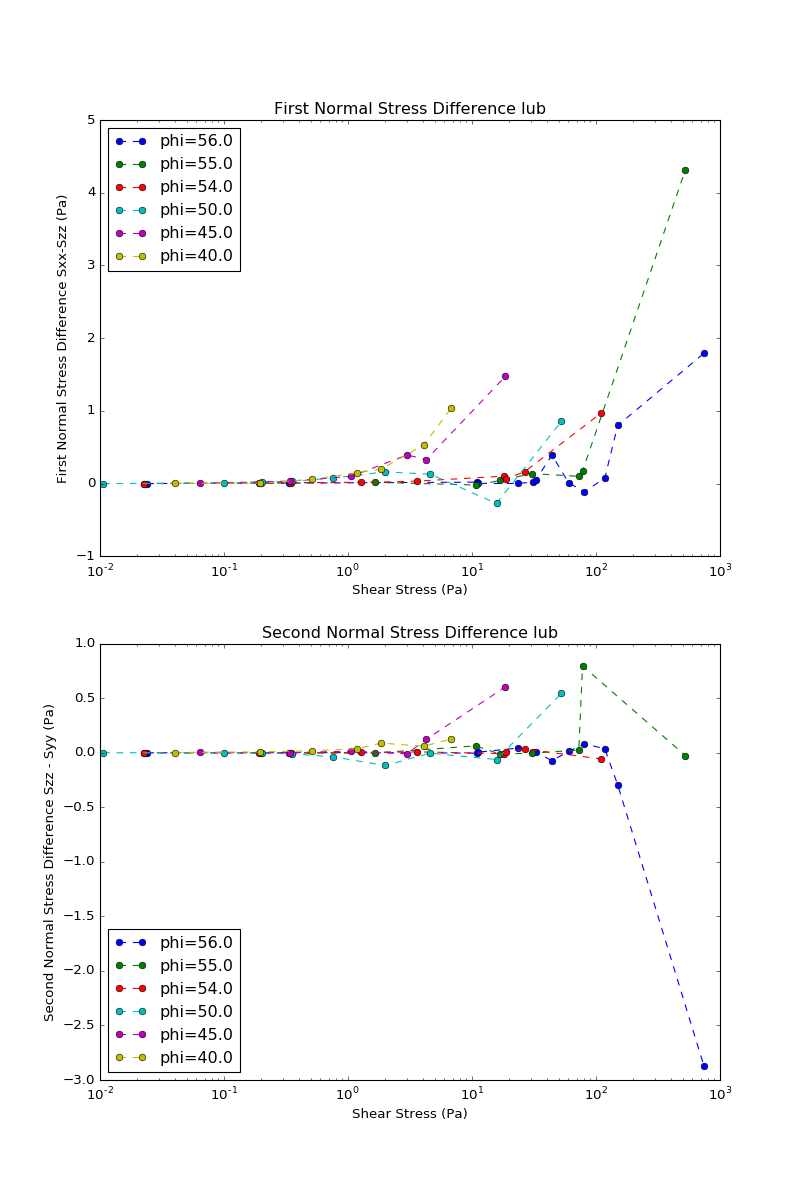

<IPython.core.display.Javascript object>


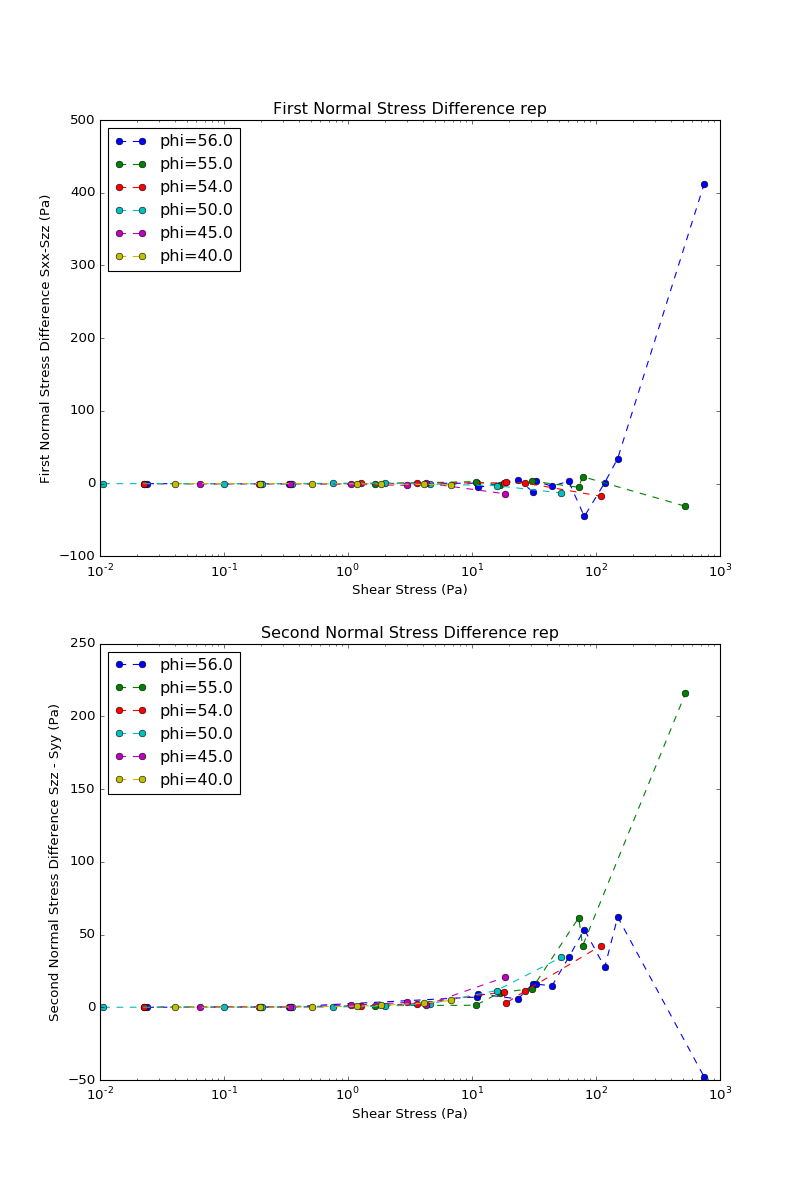

<IPython.core.display.Javascript object>


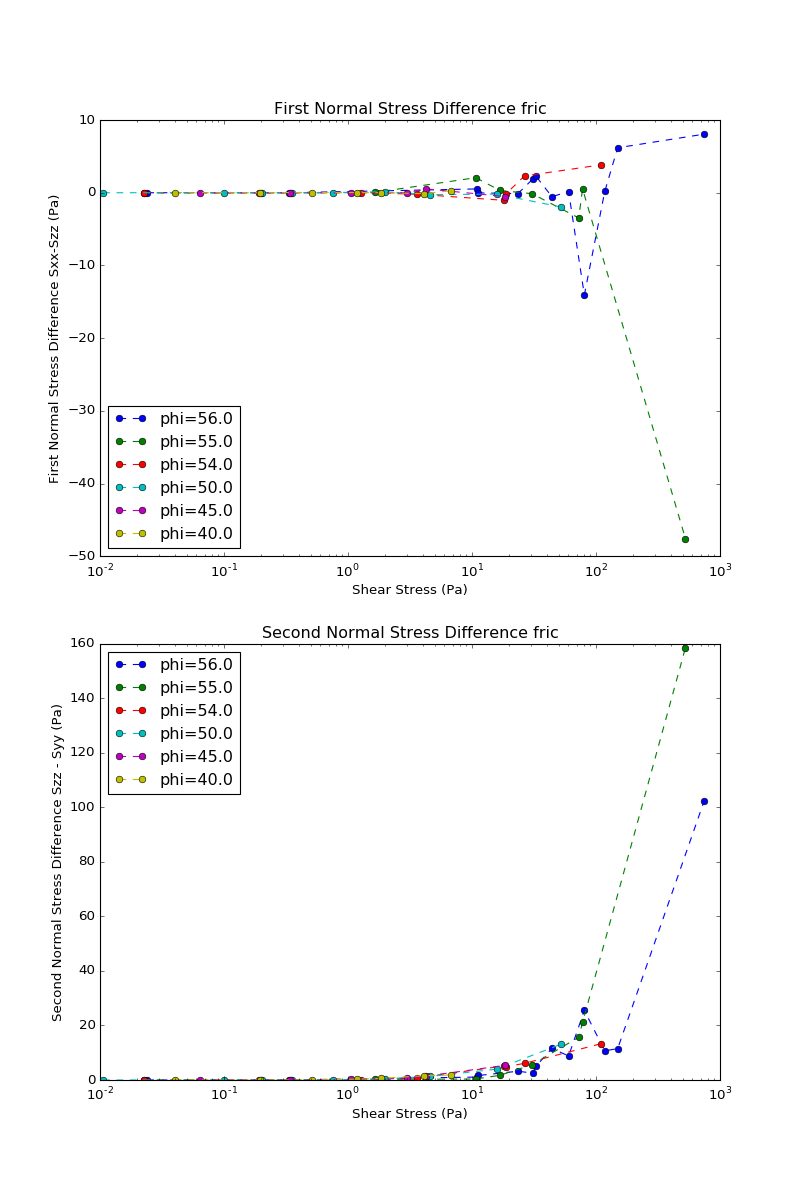

In [23]:
philist = [56.,55.,54.,50.,45.,40.]
for ia in ialist:
    plt.figure(figsize=[10,15])
    plt.subplot(211)
    plt.title("First Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')
    #     plt.yscale('symlog')
        try:
            X,Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
            plt.plot(X,Y,'--o',label="phi="+str(p))
            plt.legend(loc="top left")
            plt.xlabel('Shear Stress (Pa)')
            plt.ylabel('First Normal Stress Difference Sxx-Szz (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.subplot(212)
    plt.title("Second Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')
    #     plt.yscale('symlog')
        try:
            X, Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
            plt.plot(X, Y ,'--o',label="phi="+str(p))
            plt.legend(loc="top left")
            plt.xlabel('Shear Stress (Pa)')
            plt.ylabel('Second Normal Stress Difference Szz - Syy (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.savefig('NormalStressDifference_vs_shearrate_'+ia+'.png')